Author: Philippe Nadon

# Project Description
## Introduction
Oftentimes in electrical engineering, the voltage at each node in a circuit needs to be known to understand how the circuit works. As the complexity of the circuit grows, it becomes increasingly diﬃcult or even impossible to use many of the common ways of solving the circuit, let alone doing it by hand.

## Problem Definition
To solve this problem one would need to take a circuit and represent it in a textual manner (ie. a dataframe).

The dataframe would then need to be fed into an algorithm, which analyzes each component and outputs the value of every unknown in the circuit (eg. the voltage at each node) based on the relationship between each component, at discrete time intervals to simulate the current ﬂow throughout the circuit.

The challenge of such a tool, is attempting to speed up the simulation of the circuit, since due to the data dependency between each time step, one cannot distribute the work per time step to multiple processes. The most parallelizable area is solving the system of linear equations.

## Solution
Thus, a solution is to algorithmically implement Modiﬁed Nodal Analysis (MNA); a technique which is guaranteed to solve any circuit. To speed up computation time, the MNA implementation can be parallelized, which is greatly appreciated when working with very large and complex circuits.

The way the MNA algorithm works is that it takes the textual representation of the circuit, assembles a system of linear equations based oﬀ the known values of the components in the circuit, and solves for the unknowns in these equations. Due to the variation in the current sources, the voltage and current will vary in the circuit with respect to time, and thus the solver will repeatedly solve for these unknowns at each time step.

Thus, the computation resembles the form of Ax = b.

# Introduction to Tool
This project explores methods in which one can implement a circuit analysis tool, using [Modified Nodal Analysis](https://en.wikipedia.org/wiki/Modified_nodal_analysis). A large portion of the work in this project is thanks to [this tutorial](https://lpsa.swarthmore.edu/Systems/Electrical/mna/MNA1.html), which was immensely useful in developing this software.

The code was implemented in Python, using the typical scientific libraries (Numpy, Scipy, Pandas), as well as CuPy, which serves as a wrapper for Python code to interact with CUDA.

# Techniques Used
## Modified Nodal Analysis
The algorithm uses Modified Nodal Analysis to construct a system of linear equations, which is then solved on the CPU or GPU. As a result, both algorithm design and parallelism were part of the learning experience for making this tool.

Modified Nodal Analysis is a way of 

## Random Circuit Generator
To test for varying sizes and densities of circuits, a random circuit generator was developed. This circuit generator ensures that any two nodes on the circuit forms a cycle, and that the distribution of connections is well varied and distributed, using various algorithms as well as a [gamma distribution](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.gamma.html). Thus, this project also involves some graph theory.

## Sparse Linear Solver
Both a [CPU-based solver](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html) and a [GPU-based solver](https://docs-cupy.chainer.org/en/stable/reference/generated/cupyx.scipy.sparse.linalg.lsqr.html) were used, to compare the performance of both. Some knowledge on how CUDA works was required to use the GPU-based solver, which will be explained below.

Both solvers compute the least-squares solution for a sparse linear system of equations. Meaning, the values in x correspond to the minimum value of $||b - Ax||^2$, within a certain tolerance.

# About CUDA
The following information is from Cheng, Jie. “Programming Massively Parallel Processors. A Hands-on Approach.” *Scalable Computing: Practice and Experience 11* (2010): n. pag.

CUDA is a parallel computing platform released by NVIDIA in 2007, and was designed to tackle numerically-intensive tasks in parallel. CUDA offers developers an interface where they can directly execute code using the cores on a GPU. Because a GPU has many more cores than a CPU, its total throughput is orders of magnitude greater than that of a typical CPU. Since GPUs are typically used for graphics processing, they are especially adept at matrix computations, and thus performing linear solves on a GPU should have some real-world advantages over typical CPUs.

One significant bottleneck to CUDA computing, is the latency between beginning the transfer of data to the GPU through the PCIe lanes, and beginning the computation on the GPU. High levels of memory transfer between main memory and the dedicated GPU memory can slow down the computation, and so one must ensure that the amount of time spent transferring data is minimal.

# About Least Squares Solver
From: Prikopa, Karl E. et al. “Parallel iterative refinement linear least squares solvers based on all-reduce operations.” *Parallel Computing 57* (2016): 167-184.

There are actually many variations of the Least Squares solver, the main one being the All-Reduce Parallel Linear Least Squares (ARPLS) Solver.

There are 3 main steps involved in this solver:

1. Parallel QR Factorization
2. Parallel Matrix-vector multiplication, with 1+ local triangular solves
3. IR to stabilize and improve solution (only if >1 local triangular solves)

There are also 2 types of QR factorization: 
1. All-Reduce Modified Gram-Schmidt, best for average-case matrices
2. Tall-Skinny QR, best for narrow matrices

In summary, the matrix A is split into QR, Q being an orthogonal matrix, and R being an upper triangular matrix. Then, both are combined into the solution using matrix-vector multiplication and an All-Reduce operation.

# Specifications of Hardware Used
Intel i5 4690, 4 cores at 3.5GHz, turbo boosting up to 3.9GHz

16GB DDR3 main memory

NVIDIA GTX 970 with 4GB of GDDR5 memory, 1664 CUDA cores at 1050MHz

# Results
The results are displayed below, first is the resulting CSV containing the times for each type of solver, per matrix size and node density:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Time per matrix size, CPU vs GPU (CUDA)

In [2]:
df = pd.read_csv("stats.csv")
df = df.dropna().drop(columns=['fname', 'transfer', 'solve'])
pd.set_option('display.max_rows', 20)
df

,matrix_size,num_nodes,avg_connect,num_components,processor,total
0,1,2,2,3,cuda,0.643223
1,1,2,2,3,cpu,0.000703
2,4,4,2,6,cuda,0.003000
3,4,4,2,6,cpu,0.001081
4,7,5,2,8,cuda,0.003379
...,...,...,...,...,...,...
81,2585,1448,3,4341,cpu,0.711151
82,3600,2048,3,6141,cuda,0.883403
83,3600,2048,3,6141,cpu,1.156598
84,5031,2896,3,8684,cuda,2.048458


Plotting the time taken versus the matrix size gives us the following:

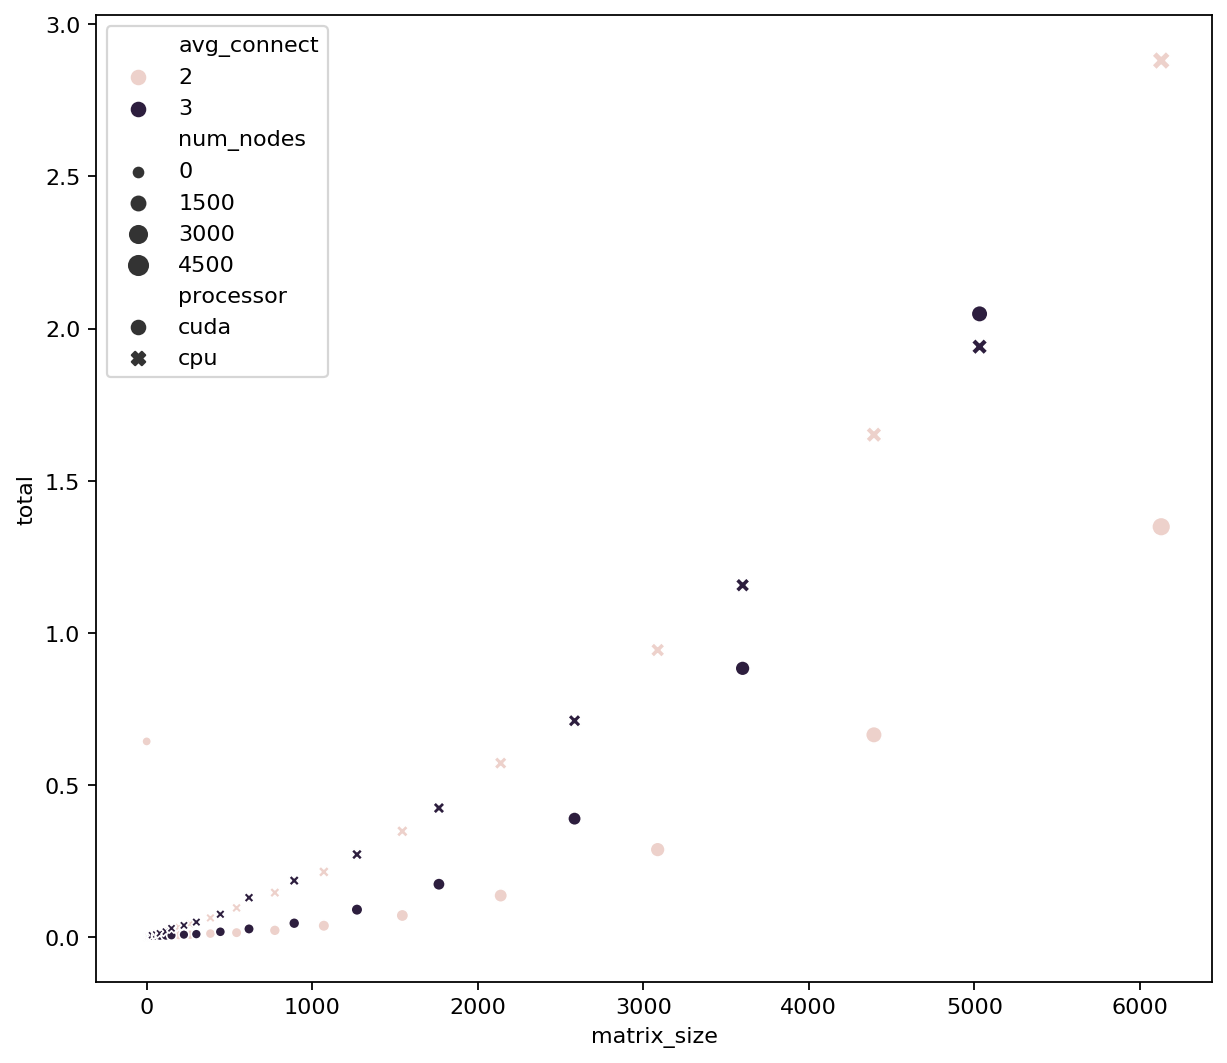

In [3]:
fig=plt.figure(figsize=(9, 8), dpi= 160, facecolor='w', edgecolor='k')
g = sns.scatterplot(x="matrix_size", y="total", hue="avg_connect", style="processor", size="num_nodes", data=df)

- The avg_connect represents the average number of connections each node has, as the average connectivity increases, so does the complexity and density of the matrix.
- processor denotes which processor was used to compute the solution, either the GPU or the CPU
- The matrix size is simply the height or width of the A matrix
- total denotes the total computation time required to solve the linear system, including data transfer to each respective processor

We can see here that the GPU is consistently faster than the CPU for almost every matrix size. However, for matrix sizes / connectivity higher than the ones displayed, the GPU failed to produce any output as a result of insufficient bandwidth / memory.

## Speedup (CPU time / GPU time)

In [4]:
cuda_df = df[df["processor"] == "cuda"].copy().reset_index().drop(columns=['index', 'processor'])
cpu_df = df[df["processor"] == "cpu"].copy().reset_index()
cuda_df["speedup"] =  cpu_df["total"] / cuda_df["total"]
cuda_df

,matrix_size,num_nodes,avg_connect,num_components,total,speedup
0,1,2,2,3,0.643223,0.001093
1,4,4,2,6,0.003000,0.360455
2,7,5,2,8,0.003379,0.604522
3,9,8,2,14,0.002350,0.581897
4,15,11,2,18,0.002459,1.092096
...,...,...,...,...,...,...
38,1271,724,3,2168,0.090257,3.008179
39,1766,1024,3,3068,0.173838,2.440557
40,2585,1448,3,4341,0.389336,1.826575
41,3600,2048,3,6141,0.883403,1.309253


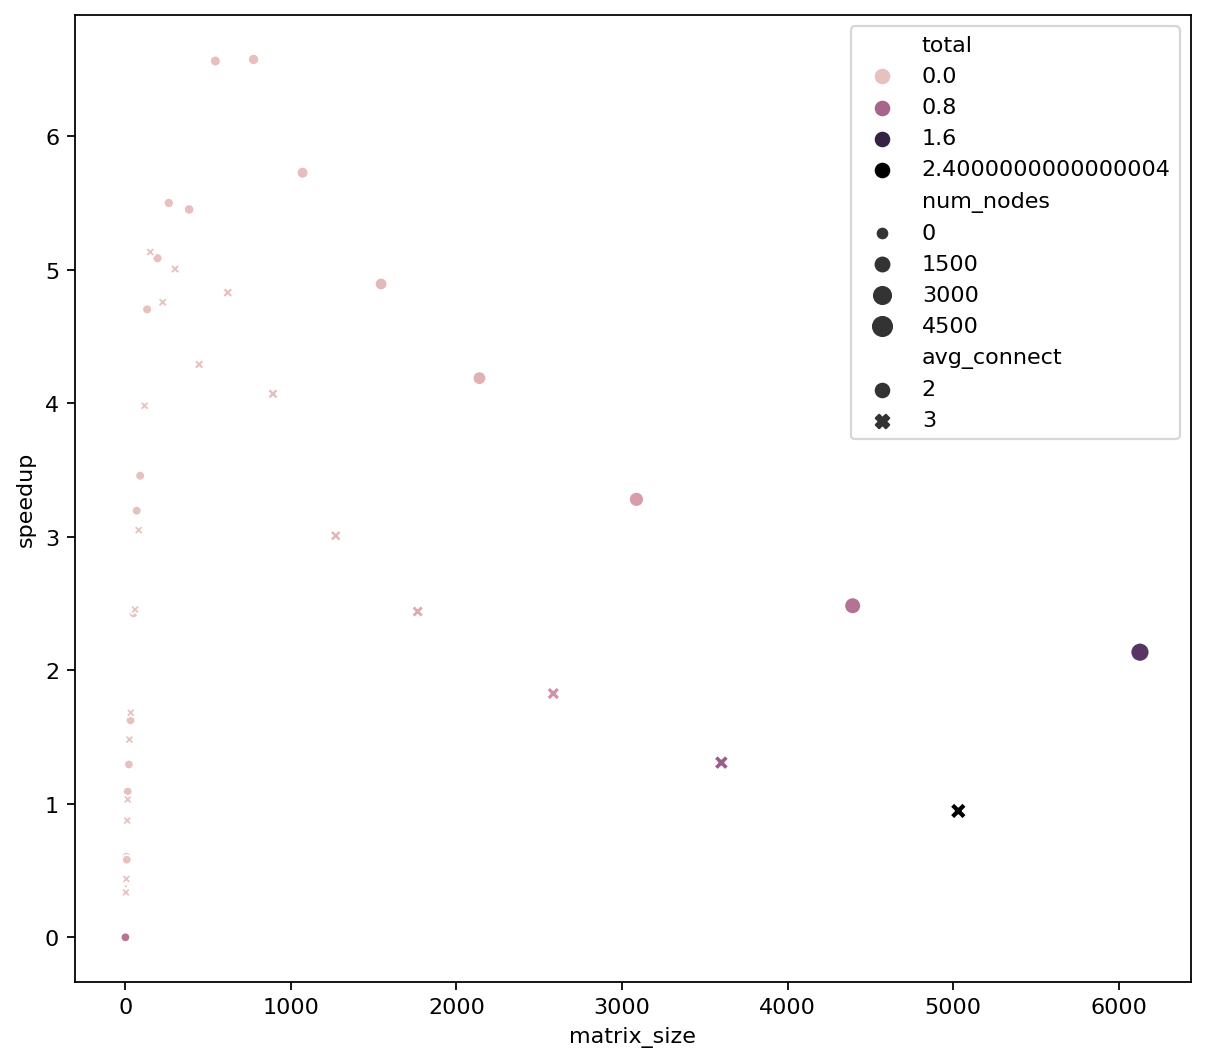

In [5]:
fig=plt.figure(figsize=(9, 8), dpi= 160, facecolor='w', edgecolor='k')
cmap = sns.cubehelix_palette(light=0.8, dark=0, as_cmap=True)
g = sns.scatterplot(x="matrix_size", y="speedup", hue="total", palette=cmap, style="avg_connect", size="num_nodes", data=cuda_df)

This graph shows an evident speedup for medium-sized matrices (~500 - 1200), but starts to decline as the matrix becomes larger. While the lower connectivity seems to approach a speedup of 1, the higher connectivity actually drops below 1, meaning the overhead caused by the denser matrix actually causes the overall GPU computation to take more time than the CPU computation, and will approach some value between 1 and 0.

# Analysis and Conclusion

## GPU Scalability

It is apparent that given a processing unit with more cores, one can scale this problem much more efficiently. The GPU offers far more potential for parallel computing than a typical CPU, as the total throughput across all of its cores dwarves that of a CPU. Given enough dedicated GPU memory, and high enough bandwidth along the PCIe lanes, one could expect considerable speedups in computation even at very large matrix sizes, making the GPU far more scalable than a typical CPU.

## GPU limitations

As we can see, oftentimes the GPU is far faster than the CPU. However, at very large matrix sizes this becomes problematic, and the data transfer overhead becomes far more dominant than the linear solver. As a result, the CPU becomes more efficient, as the GPU must pull memory from main memory before performing computations, which is a costly task. Since the GPU has far less memory (4GB) compared to main memory (16GB), the memory cost of parallelization may not always be worthwhile. As a program is parallelized, the memory costs increase (since each independant procedure must obtain its own version of the code and initialize its own local variables), and so obtaining a GPU which contains more memory may be worthwhile. CUDA is still quite efficient in this procedure, as it uses a Shared Memory Model, meaning the matrix is not needlessly duplicated across each core. Instead, a single matrix is accessed by many cores so that memory consumption is minimized.

Given that the GPU used in this experiment is neither a modern model, nor designed for scientific computing, one could conclude that GPUs which are specifically designed for scientific computing will be able to offer much larger speedups across a far wider range of matrix sizes, when compared to the solution used in this experiment.

The Python wrapper may also have some overheard, and could be more efficient. Using a lower-level package may be more complicated but result in faster computations. However, comparing Python GPU packages is outside the scope of this project.